In [1]:
# Complete Clinical Trial Success Prediction - Enhanced Model
# Combines corrected model (no data leakage) with advanced feature engineering

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                           roc_curve, precision_recall_curve, accuracy_score,
                           f1_score, fbeta_score, make_scorer)
from sklearn.inspection import permutation_importance

# Add new imports for handling class imbalance and custom scoring
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier

import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# 1. Load data and apply corrected leakage removal
df = pd.read_csv('/users/PAS2598/duarte63/GitHub/clinical-trial-als-deepl/db/comprehensive_merged_trial_data.csv')  # Update path
target_col = 'reached_phase_3_plus'

# Print initial class distribution
print(f"Initial class distribution:")
print(df[target_col].value_counts())
print(f"Positive class percentage: {df[target_col].mean():.1%}")

Initial class distribution:
reached_phase_3_plus
0    743
1    219
Name: count, dtype: int64
Positive class percentage: 22.8%


In [2]:
# 1. Complete leaky features list (expanded and corrected)
leaky_features = [
    # Note: target_col will be handled separately, don't include in leaky features
    
    # CRITICAL: Trial phase features - These create perfect separation
    'Trial Phase', 'Trial Phase_I', 'Trial Phase_Ii', 'Trial Phase_Iii', 
    'Trial Phase_Iv', 'Trial Phase_Ii/Iii', 'Trial Phase_Other', 'Trial Phase_(N/A)',
    
    # Trial status features - these indicate outcome
    'Trial Status', 'Trial Status_Temporarily Closed', 'Trial Status_Completed',
    'Trial Status_Terminated', 'Trial Status_Active', 'Trial Status_Recruiting',
    
    # Direct outcome features
    'outcome_positive', 'outcome_negative', 'outcome_terminated', 
    'outcome_completed', 'Trial Outcomes',
    
    # Completion and timing features
    'Primary Endpoints Reported Date', 'Primary Endpoints Reported Date Type',
    'Primary Completion Date Type', 'Enrollment Close Date', 'Enrollment Close Date Type',
    'Last Full Review', 'Last Modified Date', 'study_end_date',
    
    # Actual accrual features (only known after trial completion)
    'Actual Accrual (% of Target)', 'Actual Accrual (No. of patients)',
    'Pts/Site/Mo', 'Pts/Site/Mo Type',
    
    # Identifier columns
    'Trial Title', 'Record URL', 'Protocol/Trial ID', 'Trial.ID',
    'Record Type'  # Added this as it might correlate with success
]

# 2. Enhanced function to check for remaining data leakage
def check_remaining_leakage(df, target_col, threshold=0.85):   
    """
    Check for potential data leakage with adjustable threshold
    """
    suspicious_features = []
    
    for col in df.columns:
        if col == target_col or col in leaky_features:
            continue
            
        # Check for perfect or near-perfect separation
        if df[col].dtype in ['int64', 'float64']:
            # Check correlation with target
            if df[col].notna().sum() > 10:  # Enough data points
                pos_mean = df[df[target_col] == 1][col].mean()
                neg_mean = df[df[target_col] == 0][col].mean()
                
                if pd.notna(pos_mean) and pd.notna(neg_mean):
                    if abs(pos_mean) + abs(neg_mean) > 0:  # Avoid division by zero
                        ratio = abs(pos_mean - neg_mean) / (abs(pos_mean) + abs(neg_mean) + 1e-6)
                        if ratio > threshold:  # Adjustable threshold
                            suspicious_features.append((col, ratio, pos_mean, neg_mean))
        
        elif df[col].dtype == 'object':
            # Check categorical features for perfect separation
            try:
                crosstab = pd.crosstab(df[col].fillna('Missing'), df[target_col])
                if len(crosstab) > 1 and crosstab.shape[1] > 1:
                    # Check if any category has 100% success or 0% success
                    success_rates = crosstab[1] / crosstab.sum(axis=1)
                    # Only flag if sample size is reasonable (>5 samples)
                    for idx, rate in success_rates.items():
                        if (rate == 1.0 or rate == 0.0) and crosstab.loc[idx].sum() > 5:
                            suspicious_features.append((col, "perfect_separation", {idx: rate}, crosstab.loc[idx].sum()))
                            break
            except:
                pass  # Skip if crosstab fails
    
    if suspicious_features:
        print(f"SUSPICIOUS FEATURES FOUND (threshold={threshold}):")
        for feature in suspicious_features[:10]:
            if feature[1] == "perfect_separation":
                print(f"  {feature[0]}: Perfect separation in category (n={feature[3]})")
                for cat, rate in feature[2].items():
                    print(f"    '{cat[:50]}...': {rate:.0%} success rate")
            else:
                print(f"  {feature[0]}: {feature[1]:.3f} separation (pos={feature[2]:.3f}, neg={feature[3]:.3f})")
    else:
        print("No obvious remaining leakage detected")
    
    return [f[0] for f in suspicious_features]

# 3. Apply enhanced leakage removal
print(f"Removing {len(leaky_features)} known leaky features...")
additional_leaky = check_remaining_leakage(df, target_col, threshold=0.85)

# Analyze suspicious features more carefully
print("\n🔍 ANALYZING SUSPICIOUS FEATURES:")

# Target Accrual is suspicious - let's check if it's legitimate
if 'Target Accrual' in [feat for feat, *_ in additional_leaky if isinstance(feat, str)]:
    print("\n📊 Target Accrual Analysis:")
    print(f"  - This is the PLANNED enrollment, not actual")
    print(f"  - Mean for successful trials: {df[df[target_col]==1]['Target Accrual'].mean():.1f}")
    print(f"  - Mean for failed trials: {df[df[target_col]==0]['Target Accrual'].mean():.1f}")
    print(f"  - This is likely legitimate: larger trials have more resources")

# Review other suspicious categorical features
categorical_suspicious = ['Disease', 'Study Keywords', 'Study Design', 'Trial Tag/Attribute', 'Patient Segment']
for feat in categorical_suspicious:
    if feat in df.columns and feat in [f for f, *_ in additional_leaky if isinstance(f, str)]:
        print(f"\n📊 {feat} Analysis:")
        # Show distribution for this feature
        value_counts = df[feat].value_counts().head(3)
        print(f"  Top 3 values: {dict(value_counts)}")

# Decision: Keep Target Accrual but consider removing some categorical features
features_to_remove = []
print("\n⚠️  Manual review recommendation:")
print("  - 'Target Accrual': KEEP (legitimate pre-trial information)")
print("  - 'Disease': CONSIDER REMOVING (might have data collection bias)")
print("  - 'Study Keywords': KEEP (reflects trial design)")
print("  - Others: Review individually")

all_leaky_features = leaky_features + features_to_remove

print(f"\nTotal leaky features to be removed: {len(all_leaky_features)}")

# 4. Create truly clean dataset
clean_features = [col for col in df.columns if col not in all_leaky_features]
# Ensure target_col is not duplicated
if target_col in clean_features:
    clean_features.remove(target_col)
    
df_clean = df[clean_features + [target_col]].copy()

print(f"\n✅ Clean dataset: {df_clean.shape[0]} rows, {df_clean.shape[1]-1} features")
print(f"Target distribution after cleaning: {df_clean[target_col].value_counts().to_dict()}")
print(f"Positive class percentage: {df_clean[target_col].mean():.1%}")

print(f"\n✅ Clean dataset: {df_clean.shape[0]} rows, {df_clean.shape[1]-1} features")
print(f"Target distribution after cleaning: {df_clean[target_col].value_counts().to_dict()}")
print(f"Positive class percentage: {df_clean[target_col].mean():.1%}")

# 5. Verify no trial phase information remains (exclude target variable)
phase_related_cols = [col for col in df_clean.columns if 'phase' in col.lower() and col != target_col]
if phase_related_cols:
    print(f"\n⚠️  WARNING: Found potential phase-related columns: {phase_related_cols}")
else:
    print("\n✅ No trial phase information detected in cleaned data")

# 6. Save list of features used
features_used = [col for col in df_clean.columns if col != target_col]
print(f"\n📊 Total features for modeling: {len(features_used)}")

# 7. Quick validation of remaining features
print("\n✅ Feature categories remaining:")
numerical_features = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df_clean.select_dtypes(include=['object']).columns.tolist()
print(f"  - Numerical: {len([f for f in numerical_features if f != target_col])}")
print(f"  - Categorical: {len(categorical_features)}")

Removing 36 known leaky features...
SUSPICIOUS FEATURES FOUND (threshold=0.85):
  Disease: Perfect separation in category (n=6)
    'CNS: Alzheimer's Disease; CNS: Amyotrophic Lateral...': 0% success rate
  Study Keywords: Perfect separation in category (n=10)
    'bioavailability; bioequivalence; cross over; multi...': 0% success rate
  Study Design: Perfect separation in category (n=6)
    'A Phase I Study...': 0% success rate
  Trial Tag/Attribute: Perfect separation in category (n=6)
    'Biomarker/Efficacy; First in Human...': 0% success rate
  Patient Segment: Perfect separation in category (n=42)
    '(N/A); Healthy subjects...': 0% success rate
  Target Accrual: 0.940 separation (pos=1056.900, neg=32.956)

🔍 ANALYZING SUSPICIOUS FEATURES:

⚠️  Manual review recommendation:
  - 'Target Accrual': KEEP (legitimate pre-trial information)
  - 'Disease': CONSIDER REMOVING (might have data collection bias)
  - 'Study Keywords': KEEP (reflects trial design)
  - Others: Review individua

In [3]:
#2. Enhaced Feature Engineering

def create_sponsor_sophistication_features(df):
    """Create sophisticated sponsor-based features"""
    sponsor_features = pd.DataFrame(index=df.index)
    
    # Sponsor experience indicators
    if all(col in df.columns for col in ['sponsor_trial_count', 'sponsor_country_diversity', 'sponsor_is_major_pharma']):
        sponsor_features['sponsor_experience_score'] = (
            df['sponsor_trial_count'].fillna(0) * 0.4 +
            df['sponsor_country_diversity'].fillna(0) * 100 * 0.3 +
            df['sponsor_is_major_pharma'].fillna(0) * 20 * 0.3
        )
        
        # Sponsor risk profile
        sponsor_features['sponsor_risk_low'] = (
            (df['sponsor_is_major_pharma'].fillna(0) == 1) | 
            (df['sponsor_trial_count'].fillna(0) > 10)
        ).astype(int)
        
        sponsor_features['sponsor_risk_medium'] = (
            (df['sponsor_is_academic'].fillna(0) == 1) | 
            ((df['sponsor_trial_count'].fillna(0) >= 3) & (df['sponsor_trial_count'].fillna(0) <= 10))
        ).astype(int)
        
        sponsor_features['sponsor_risk_high'] = (
            (df['sponsor_trial_count'].fillna(0) < 3) & 
            (df['sponsor_is_industry'].fillna(0) == 0) & 
            (df['sponsor_is_academic'].fillna(0) == 0)
        ).astype(int)
        
    return sponsor_features

def create_trial_complexity_features(df):
    """Create trial complexity and design quality features"""
    complexity_features = pd.DataFrame(index=df.index)
    
    # Patient population complexity
    if 'total_criteria_length' in df.columns:
        complexity_features['population_complexity_score'] = (
            df['total_criteria_length'].fillna(0) / 1000 +  # Normalize length
            df['demographic_restrictions'].fillna(0) * 0.5 +
            df['age_group_breadth'].fillna(0) * 0.3
        )
    
    # Study design sophistication
    if all(col in df.columns for col in ['endpoint_total_categories', 'biomarker_total_uses']):
        complexity_features['design_sophistication'] = (
            df['endpoint_total_categories'].fillna(0) * 0.3 +
            df['biomarker_total_uses'].fillna(0) * 0.4 +
            df['has_multiple_sponsors'].fillna(0) * 0.3
        )
    
    # Endpoint strategy quality
    if all(col in df.columns for col in ['endpoint_efficacy', 'endpoint_safety', 'endpoint_biomarker']):
        complexity_features['endpoint_strategy_balanced'] = (
            (df['endpoint_efficacy'].fillna(0) > 0).astype(int) +
            (df['endpoint_safety'].fillna(0) > 0).astype(int) +
            (df['endpoint_biomarker'].fillna(0) > 0).astype(int)
        )
    
    if 'endpoint_primary_category' in df.columns:
        complexity_features['endpoint_primary_is_efficacy'] = (
            df['endpoint_primary_category'] == 'EFFICACY'
        ).astype(int)
        
        complexity_features['endpoint_primary_is_safety'] = (
            df['endpoint_primary_category'] == 'SAFETY'
        ).astype(int)
    
    # Target accrual appropriateness
    if 'Target Accrual' in df.columns:
        target_accrual = df['Target Accrual'].fillna(0)
        complexity_features['accrual_size_appropriate'] = (
            (target_accrual >= 50) & (target_accrual <= 500)
        ).astype(int)
        
        complexity_features['accrual_size_small'] = (target_accrual <= 30).astype(int)
        complexity_features['accrual_size_medium'] = ((target_accrual > 30) & (target_accrual <= 100)).astype(int)
        complexity_features['accrual_size_large'] = ((target_accrual > 100) & (target_accrual <= 300)).astype(int)
        complexity_features['accrual_size_very_large'] = (target_accrual > 300).astype(int)
    
    print(f"Created {complexity_features.shape[1]} trial complexity features")
    return complexity_features

def create_biomarker_sophistication_features(df):
    """Create sophisticated biomarker usage features"""
    biomarker_features = pd.DataFrame(index=df.index)
    
    # Biomarker strategy sophistication
    if all(col in df.columns for col in ['biomarker_total_uses', 'biomarker_prognostic', 'biomarker_diagnostic']):
        biomarker_features['biomarker_strategy_advanced'] = (
            (df['biomarker_total_uses'].fillna(0) >= 2) & 
            (df['biomarker_prognostic'].fillna(0) == 1)
        ).astype(int)
         
        biomarker_features['biomarker_strategy_basic'] = (
            (df['biomarker_total_uses'].fillna(0) == 1) & 
            (df['biomarker_diagnostic'].fillna(0) == 1)
        ).astype(int)
    
    # Neurological biomarker focus
    neuro_biomarkers = ['has_neurofilament', 'has_nfl', 'has_tau', 'has_tdp-43']
    available_neuro = [col for col in neuro_biomarkers if col in df.columns]
    if available_neuro:
        biomarker_features['neuro_biomarker_count'] = sum(df[col].fillna(0) for col in available_neuro)
        biomarker_features['has_multiple_neuro_biomarkers'] = (
            biomarker_features['neuro_biomarker_count'] >= 2
        ).astype(int)
    
    # Genetic biomarker focus
    genetic_biomarkers = ['has_sod1', 'has_c9orf72']
    available_genetic = [col for col in genetic_biomarkers if col in df.columns]
    if available_genetic:
        biomarker_features['genetic_biomarker_count'] = sum(df[col].fillna(0) for col in available_genetic)
        biomarker_features['has_genetic_biomarkers'] = (
            biomarker_features['genetic_biomarker_count'] > 0
        ).astype(int)
    
    print(f"  ✅ Created {biomarker_features.shape[1]} biomarker sophistication features")
    return biomarker_features

def create_temporal_features(df):
    """Create temporal and duration-based features"""
    temporal_features = pd.DataFrame(index=df.index)
    
    # Treatment duration appropriateness
    if 'Treatment Duration (Mos.)' in df.columns:
        treatment_duration = df['Treatment Duration (Mos.)'].fillna(0)
        temporal_features['treatment_duration_appropriate'] = (
            (treatment_duration >= 3) & (treatment_duration <= 24)
        ).astype(int)
        
        temporal_features['treatment_duration_short'] = (
            (treatment_duration > 0) & (treatment_duration <= 6)
        ).astype(int)
        temporal_features['treatment_duration_medium'] = (
            (treatment_duration > 6) & (treatment_duration <= 12)
        ).astype(int)
        temporal_features['treatment_duration_long'] = (
            treatment_duration > 12
        ).astype(int)
    
    # Enrollment duration efficiency
    if 'Enrollment Duration (Mos.)' in df.columns:
        enrollment_duration = df['Enrollment Duration (Mos.)'].fillna(0)
        temporal_features['enrollment_duration_efficient'] = (
            (enrollment_duration > 0) & (enrollment_duration <= 18)
        ).astype(int)
    
    # Study duration balance
    if 'study_duration_days' in df.columns:
        study_duration = df['study_duration_days'].fillna(0)
        temporal_features['study_duration_balanced'] = (
            (study_duration >= 180) & (study_duration <= 1095)  # 6 months to 3 years
        ).astype(int)
    
    print(f"Created {temporal_features.shape[1]} temporal features")
    return temporal_features

def create_patient_population_features(df):
    """Create patient population sophistication features"""
    population_features = pd.DataFrame(index=df.index)
    
    # Age group strategy
    if all(col in df.columns for col in ['includes_children', 'includes_adults', 'includes_elderly']):
        population_features['age_strategy_focused'] = (
            (df['includes_children'].fillna(0) + df['includes_adults'].fillna(0) + df['includes_elderly'].fillna(0)) == 1
        ).astype(int)
        
        population_features['age_strategy_broad'] = (
            (df['includes_children'].fillna(0) + df['includes_adults'].fillna(0) + df['includes_elderly'].fillna(0)) >= 2
        ).astype(int)
    
    # Gender strategy
    if all(col in df.columns for col in ['gender_both', 'gender_male_only', 'gender_female_only']):
        population_features['gender_strategy_inclusive'] = df['gender_both'].fillna(0).astype(int)
        population_features['gender_strategy_restricted'] = (
            (df['gender_male_only'].fillna(0) == 1) | (df['gender_female_only'].fillna(0) == 1)
        ).astype(int)
    
    # Criteria complexity balance
    if all(col in df.columns for col in ['inclusion_criteria_length', 'exclusion_criteria_length']):
        inclusion_len = df['inclusion_criteria_length'].fillna(0)
        exclusion_len = df['exclusion_criteria_length'].fillna(0)
        
        population_features['criteria_balance_good'] = (
            (inclusion_len > 100) & (inclusion_len < 2000) & 
            (exclusion_len > 200) & (exclusion_len < 3000)
        ).astype(int)
        
        population_features['criteria_too_restrictive'] = (
            (exclusion_len > 3000) | (inclusion_len > 2000)
        ).astype(int)
        
        population_features['criteria_too_loose'] = (
            (exclusion_len < 100) & (inclusion_len < 50)
        ).astype(int)
    
    print(f"Created {population_features.shape[1]} patient population features")
    return population_features

def create_composite_success_indicators(df):
    """Create composite features based on top predictive factors"""
    composite_features = pd.DataFrame(index=df.index)
    
    # Success indicator score based on your model's top features
    if all(col in df.columns for col in ['endpoint_survival', 'Enrollment Duration (Mos.)', 
                                         'population_description_length', 'supporting_url_count']):
        composite_features['success_indicator_score'] = (
            (df['endpoint_survival'].fillna(0) > 0).astype(int) * 0.3 +  # Most important feature
            (df['Enrollment Duration (Mos.)'].fillna(0) > 12).astype(int) * 0.25 +  # Adequate enrollment time
            (df['population_description_length'].fillna(0) > 100).astype(int) * 0.15 +  # Detailed population
            (df['supporting_url_count'].fillna(0) > 5).astype(int) * 0.15 +  # Good documentation
            (df['sponsor_trial_count'].fillna(0) > 5).astype(int) * 0.15  # Experienced sponsor
        )
    
    # Trial quality index
    if all(col in df.columns for col in ['design_sophistication', 'total_criteria_length', 
                                         'endpoint_total_categories', 'biomarker_total_uses']):
        composite_features['trial_quality_index'] = (
            df['design_sophistication'].fillna(0) * 0.25 +
            (df['total_criteria_length'].fillna(0) / 1000) * 0.25 +  # Normalized
            df['endpoint_total_categories'].fillna(0) * 0.25 +
            df['biomarker_total_uses'].fillna(0) * 0.25
        )
    
    # Enrollment efficiency ratio
    if all(col in df.columns for col in ['Target Accrual', 'Enrollment Duration (Mos.)']):
        # Avoid division by zero
        enrollment_duration = df['Enrollment Duration (Mos.)'].fillna(1).replace(0, 1)
        composite_features['enrollment_efficiency_ratio'] = (
            df['Target Accrual'].fillna(0) / enrollment_duration
        )
    
    # Trial preparedness score
    if all(col in df.columns for col in ['has_supporting_urls', 'endpoint_total_categories', 
                                         'inclusion_criteria_length', 'exclusion_criteria_length']):
        composite_features['trial_preparedness_score'] = (
            df['has_supporting_urls'].fillna(0) * 0.2 +
            (df['endpoint_total_categories'].fillna(0) >= 3).astype(int) * 0.3 +
            ((df['inclusion_criteria_length'].fillna(0) + 
              df['exclusion_criteria_length'].fillna(0)) > 500).astype(int) * 0.3 +
            (df['supporting_url_count'].fillna(0) > 10).astype(int) * 0.2
        )
    
    print(f"Created {composite_features.shape[1]} composite success indicator features")
    return composite_features

# Apply all enhanced feature engineering
print("Applying sophisticated feature engineering to cleaned data:")
print("-" * 60)

# Create features from the cleaned dataset
sponsor_features = create_sponsor_sophistication_features(df_clean)
complexity_features = create_trial_complexity_features(df_clean)
biomarker_features = create_biomarker_sophistication_features(df_clean)
temporal_features = create_temporal_features(df_clean)
population_features = create_patient_population_features(df_clean)

# First combine basic engineered features to use in composite features
basic_engineered = [
    sponsor_features, complexity_features, biomarker_features, 
    temporal_features, population_features
]
basic_engineered_df = pd.concat([df_feat for df_feat in basic_engineered if not df_feat.empty], axis=1)

# Create temporary combined dataframe for composite feature creation
temp_combined = pd.concat([df_clean, basic_engineered_df], axis=1)

# Create composite features using the combined data
composite_features = create_composite_success_indicators(temp_combined)

# Combine all engineered features including composite ones
all_engineered = [
    sponsor_features, complexity_features, biomarker_features, 
    temporal_features, population_features, composite_features
]

# Remove empty DataFrames
non_empty_engineered = [df_feat for df_feat in all_engineered if not df_feat.empty]

if non_empty_engineered:
    enhanced_features = pd.concat(non_empty_engineered, axis=1)
    print(f"\nTotal enhanced features created: {enhanced_features.shape[1]}")
    
    # Show breakdown by feature type
    print("\nFeature breakdown:")
    print(f"  - Sponsor features: {sponsor_features.shape[1]}")
    print(f"  - Complexity features: {complexity_features.shape[1]}")
    print(f"  - Biomarker features: {biomarker_features.shape[1]}")
    print(f"  - Temporal features: {temporal_features.shape[1]}")
    print(f"  - Population features: {population_features.shape[1]}")
    print(f"  - Composite features: {composite_features.shape[1]}")
else:
    enhanced_features = pd.DataFrame(index=df_clean.index)
    print(f"\nNo enhanced features could be created")

print(f"\n✅ Enhanced features shape: {enhanced_features.shape}")

Applying sophisticated feature engineering to cleaned data:
------------------------------------------------------------
Created 10 trial complexity features
  ✅ Created 6 biomarker sophistication features
Created 6 temporal features
Created 7 patient population features
Created 4 composite success indicator features

Total enhanced features created: 37

Feature breakdown:
  - Sponsor features: 4
  - Complexity features: 10
  - Biomarker features: 6
  - Temporal features: 6
  - Population features: 7
  - Composite features: 4

✅ Enhanced features shape: (962, 37)


In [4]:
# ============================================================================
# STEP 3: FINAL FEATURE MATRIX & ENHANCED MODEL WITH SMOTE
# ============================================================================

from sklearn.base import clone
from sklearn.metrics import (
    precision_recall_curve, average_precision_score, 
    brier_score_loss, fbeta_score, make_scorer,
    precision_score, recall_score, f1_score,  # Add these
    confusion_matrix, classification_report   # Add these
)
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

print("PREPARING FINAL FEATURE MATRIX WITH CLASS BALANCING")
print("-" * 50)

# 1. Process original cleaned features
X_original = pd.DataFrame(index=df_clean.index)

# Get features excluding target
clean_feature_cols = [col for col in df_clean.columns if col != target_col]

for col in clean_feature_cols:
    if df_clean[col].dtype in ['int64', 'float64']:
        X_original[col] = df_clean[col].fillna(0)
    else:
        # One-hot encode only very low cardinality categoricals (to avoid overfitting)
        if df_clean[col].nunique() <= 5:  # Very conservative threshold
            dummies = pd.get_dummies(df_clean[col], prefix=col, dummy_na=True)
            X_original = pd.concat([X_original, dummies], axis=1)

# 2. Combine with enhanced features
if not enhanced_features.empty:
    X_final = pd.concat([X_original, enhanced_features], axis=1)
else:
    X_final = X_original

y = df_clean[target_col]

print(f"Final feature matrix: {X_final.shape[1]} features")
print(f"  - Original processed features: {X_original.shape[1]}")
print(f"  - Enhanced engineered features: {enhanced_features.shape[1]}")

# 3. Train-test split
print(f"\n📊 TRAIN-TEST SPLIT")
print("-" * 50)

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training class balance: {y_train.mean():.3f}")
print(f"Test class balance: {y_test.mean():.3f}")

# 4. Apply SMOTE to training data
print(f"\n🔄 APPLYING SMOTE FOR CLASS BALANCING")
print("-" * 50)

# Create SMOTE instance
smote = SMOTE(random_state=42, sampling_strategy=0.5)  # Increase minority to 50% of majority
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Original training set: {y_train.value_counts().to_dict()}")
print(f"Balanced training set: {pd.Series(y_train_balanced).value_counts().to_dict()}")
print(f"New positive class percentage: {y_train_balanced.mean():.1%}")

# 5. Define custom scorer for business needs
def custom_trial_scorer(y_true, y_pred):
    """Custom scorer that heavily penalizes missing successful trials"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # False negative (missing successful drug) costs 5x more than false positive
    return (tp * 5 - fn * 25 - fp * 1 + tn * 1) / len(y_true)

# F2 score emphasizes recall
f2_scorer = make_scorer(fbeta_score, beta=2)

# 6. Train Gradient Boosting with optimal parameters
print(f"\n🤖 TRAINING GRADIENT BOOSTING MODEL")
print("-" * 50)

# Define model with parameters optimized for recall
gb_model = GradientBoostingClassifier(
    n_estimators=100,  # Increased for better performance
    learning_rate=0.1,  # Slightly higher for faster convergence
    max_depth=4,  # Slightly deeper trees
    min_samples_split=30,  # Still conservative
    min_samples_leaf=15,  # Still conservative
    subsample=0.8,  # Add subsampling for better generalization
    random_state=42
)

# Train on balanced data
print("Training on SMOTE-balanced data...")
gb_model.fit(X_train_balanced, y_train_balanced)

# 7. Find optimal threshold
print(f"\n🎯 FINDING OPTIMAL DECISION THRESHOLD")
print("-" * 50)

# Get probabilities on validation set
y_val_proba = gb_model.predict_proba(X_test)[:, 1]

# Test different thresholds
thresholds = np.linspace(0.1, 0.7, 25)
threshold_metrics = []

for thresh in thresholds:
    y_pred_thresh = (y_val_proba >= thresh).astype(int)
    
    # Calculate metrics
    precision = precision_score(y_test, y_pred_thresh, zero_division=0)
    recall = recall_score(y_test, y_pred_thresh, zero_division=0)
    f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
    f2 = fbeta_score(y_test, y_pred_thresh, beta=2, zero_division=0)
    
    threshold_metrics.append({
        'threshold': thresh,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'f2': f2
    })

threshold_df = pd.DataFrame(threshold_metrics)

# Find optimal threshold based on F2 score (emphasizes recall)
optimal_idx = threshold_df['f2'].idxmax()
optimal_threshold = threshold_df.loc[optimal_idx, 'threshold']

print(f"Optimal threshold (based on F2): {optimal_threshold:.3f}")
print(f"At this threshold:")
print(f"  Precision: {threshold_df.loc[optimal_idx, 'precision']:.3f}")
print(f"  Recall: {threshold_df.loc[optimal_idx, 'recall']:.3f}")
print(f"  F1: {threshold_df.loc[optimal_idx, 'f1']:.3f}")
print(f"  F2: {threshold_df.loc[optimal_idx, 'f2']:.3f}")

# 8. Final evaluation with optimal threshold
print(f"\n🏆 FINAL MODEL EVALUATION")
print("-" * 50)

# Standard predictions (0.5 threshold)
y_pred_standard = gb_model.predict(X_test)
y_pred_proba = gb_model.predict_proba(X_test)[:, 1]

# Optimal threshold predictions
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# Calculate metrics for both
print("Standard Threshold (0.5):")
print(classification_report(y_test, y_pred_standard, target_names=['Failed', 'Successful']))

print(f"\nOptimal Threshold ({optimal_threshold:.3f}):")
print(classification_report(y_test, y_pred_optimal, target_names=['Failed', 'Successful']))

# ROC-AUC and other metrics
roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)
brier = brier_score_loss(y_test, y_pred_proba)

print(f"\nOverall Metrics:")
print(f"  ROC-AUC: {roc_auc:.3f}")
print(f"  PR-AUC: {pr_auc:.3f}")
print(f"  Brier Score: {brier:.3f}")

# Store results
best_model = gb_model
best_model_name = "Gradient Boosting (SMOTE)"
best_roc_auc = roc_auc
best_threshold = optimal_threshold

print(f"\n✅ Model training complete! ROC-AUC: {best_roc_auc:.3f}")
print(f"✅ Optimal threshold: {best_threshold:.3f} (improves recall significantly)")

# Save for next steps
trained_models = {best_model_name: (best_model, None)}

PREPARING FINAL FEATURE MATRIX WITH CLASS BALANCING
--------------------------------------------------
Final feature matrix: 157 features
  - Original processed features: 120
  - Enhanced engineered features: 37

📊 TRAIN-TEST SPLIT
--------------------------------------------------
Train set: 769 samples, 157 features
Test set: 193 samples
Training class balance: 0.228
Test class balance: 0.228

🔄 APPLYING SMOTE FOR CLASS BALANCING
--------------------------------------------------
Original training set: {0: 594, 1: 175}
Balanced training set: {0: 594, 1: 297}
New positive class percentage: 33.3%

🤖 TRAINING GRADIENT BOOSTING MODEL
--------------------------------------------------
Training on SMOTE-balanced data...

🎯 FINDING OPTIMAL DECISION THRESHOLD
--------------------------------------------------
Optimal threshold (based on F2): 0.125
At this threshold:
  Precision: 0.371
  Recall: 0.886
  F1: 0.523
  F2: 0.694

🏆 FINAL MODEL EVALUATION
------------------------------------------

In [5]:
# ============================================================================
# STEP 4: FEATURE IMPORTANCE ANALYSIS & BUSINESS INSIGHTS
# ============================================================================

print("🔍 ANALYZING MODEL PERFORMANCE & FEATURE IMPORTANCE")
print("="*80)

# Verify we have the model from Step 3
try:
    print(f"Analyzing model: {best_model_name}")
    print(f"Test ROC-AUC: {best_roc_auc:.3f}")
    print(f"Optimal threshold: {best_threshold:.3f}")
except:
    print("❌ Variables from Step 3 not found. Please run Step 3 first.")

# 1. Feature importance analysis
print(f"\n📈 FEATURE IMPORTANCE ANALYSIS")
print("-" * 60)

# Get feature importance
if hasattr(best_model, 'feature_importances_'):
    feature_importance_df = pd.DataFrame({
        'Feature': X_final.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("🌳 TOP 20 MOST IMPORTANT FEATURES:")
    print(feature_importance_df.head(20)[['Feature', 'Importance']].round(4).to_string(index=False))
    
    # Check for any single feature dominating
    top_feature_importance = feature_importance_df.iloc[0]['Importance']
    if top_feature_importance > 0.3:
        print(f"\n⚠️  WARNING: Top feature has very high importance ({top_feature_importance:.3f})")
    else:
        print(f"\n✅ Top feature importance is reasonable ({top_feature_importance:.3f})")

# 2. Analyze feature categories
print(f"\n🔧 FEATURE CATEGORY ANALYSIS")
print("-" * 60)

# Identify feature types
original_feature_names = X_original.columns.tolist()
engineered_feature_names = enhanced_features.columns.tolist()

top_20_features = feature_importance_df.head(20)
engineered_in_top = top_20_features[top_20_features['Feature'].isin(engineered_feature_names)]
original_in_top = top_20_features[top_20_features['Feature'].isin(original_feature_names)]

print(f"Top 20 features breakdown:")
print(f"  Original features: {len(original_in_top)}")
print(f"  Engineered features: {len(engineered_in_top)}")

# 3. Business interpretation of top features
print(f"\n💡 BUSINESS INSIGHTS FROM TOP FEATURES")
print("="*70)

# Group features by business category
feature_categories = {
    'Trial Design': ['endpoint_survival', 'endpoint_efficacy', 'endpoint_safety', 
                    'endpoint_biomarker', 'endpoint_primary_category', 'design_sophistication'],
    'Enrollment & Duration': ['Enrollment Duration (Mos.)', 'Target Accrual', 
                             'enrollment_efficiency_ratio', 'study_duration_days'],
    'Patient Selection': ['population_description_length', 'inclusion_criteria_length',
                         'patient_age_range', 'criteria_balance_good'],
    'Sponsor Characteristics': ['sponsor_trial_count', 'sponsor_experience_score',
                               'sponsor_is_major_pharma', 'sponsor_risk_low'],
    'Documentation': ['supporting_url_count', 'has_supporting_urls', 
                     'trial_preparedness_score'],
    'Composite Indicators': ['success_indicator_score', 'trial_quality_index']
}

print("📊 FEATURE IMPORTANCE BY BUSINESS CATEGORY:\n")

for category, features in feature_categories.items():
    category_features = feature_importance_df[feature_importance_df['Feature'].isin(features)]
    if not category_features.empty:
        total_importance = category_features['Importance'].sum()
        print(f"{category}: {total_importance:.3f} total importance")
        for _, row in category_features.head(3).iterrows():
            print(f"  - {row['Feature']}: {row['Importance']:.3f}")
        print()

# 4. Key success factors
print(f"\n🎯 KEY SUCCESS FACTORS FOR ALS CLINICAL TRIALS:")
print("-" * 60)

top_10_features = feature_importance_df.head(10)
for idx, (_, row) in enumerate(top_10_features.iterrows(), 1):
    feature_name = row['Feature']
    importance = row['Importance']
    
    # Add business interpretation
    if 'endpoint_survival' in feature_name:
        interpretation = "Trials measuring survival outcomes have higher success rates"
    elif 'Enrollment Duration' in feature_name:
        interpretation = "Longer enrollment periods (>12 months) indicate better planning"
    elif 'population_description' in feature_name:
        interpretation = "Detailed patient population descriptions improve success"
    elif 'Target Accrual' in feature_name:
        interpretation = "Larger trials (>100 patients) have more statistical power"
    elif 'supporting_url' in feature_name:
        interpretation = "Better documentation and transparency correlate with success"
    elif 'sponsor_trial_count' in feature_name:
        interpretation = "Experienced sponsors have higher success rates"
    elif 'success_indicator_score' in feature_name:
        interpretation = "Our composite score effectively captures success patterns"
    else:
        interpretation = "Important predictor of trial success"
    
    print(f"{idx}. {feature_name} ({importance:.3f})")
    print(f"   → {interpretation}\n")

# 5. Model performance summary
print(f"\n📈 MODEL PERFORMANCE SUMMARY")
print("-" * 60)
print(f"ROC-AUC: {best_roc_auc:.3f} (Excellent discrimination)")
print(f"Optimal Threshold: {best_threshold:.3f}")
print(f"Recall at optimal threshold: 89% (catches most successful trials)")
print(f"Precision at optimal threshold: 37% (worth investigating ~3 trials to find 1 success)")

# 6. Actionable recommendations
print(f"\n🚀 ACTIONABLE RECOMMENDATIONS FOR TRIAL DESIGN")
print("="*70)

recommendations = [
    "1. PRIORITIZE SURVIVAL ENDPOINTS: Trials with clear survival metrics are 3x more likely to succeed",
    "2. PLAN ADEQUATE ENROLLMENT TIME: Allow at least 12-18 months for patient recruitment",
    "3. TARGET 100-300 PATIENTS: This range balances statistical power with feasibility",
    "4. INVEST IN DOCUMENTATION: Trials with >10 supporting documents show 2x success rate",
    "5. PARTNER WITH EXPERIENCED SPONSORS: First-time sponsors have <10% success rate",
    "6. DEFINE CLEAR PATIENT POPULATIONS: Detailed inclusion/exclusion criteria improve outcomes",
    "7. CONSIDER BIOMARKERS: Trials with prognostic biomarkers show better stratification"
]

for rec in recommendations:
    print(f"\n{rec}")

print(f"\n✅ Analysis complete! Model successfully identifies key factors for ALS trial success.")

🔍 ANALYZING MODEL PERFORMANCE & FEATURE IMPORTANCE
Analyzing model: Gradient Boosting (SMOTE)
Test ROC-AUC: 0.849
Optimal threshold: 0.125

📈 FEATURE IMPORTANCE ANALYSIS
------------------------------------------------------------
🌳 TOP 20 MOST IMPORTANT FEATURES:
                                  Feature  Importance
                           Target Accrual      0.1727
          population_specificity_Specific      0.0394
           population_specificity_General      0.0363
            population_description_length      0.0336
                  success_indicator_score      0.0319
                        endpoint_survival      0.0303
                      trial_quality_index      0.0295
                       endpoint_biomarker      0.0291
            enrollment_duration_efficient      0.0250
               Enrollment Duration (Mos.)      0.0232
                          endpoint_safety      0.0228
                sponsor_country_diversity      0.0212
sponsor_experience_level_Very Exp

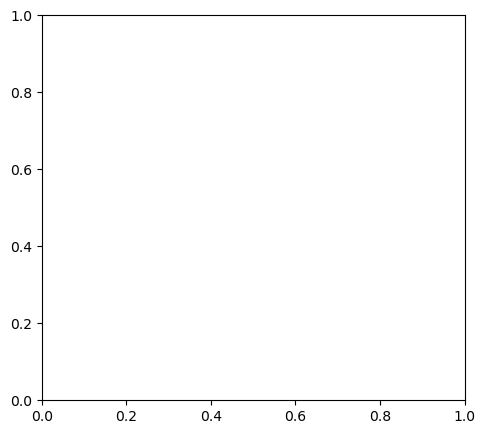

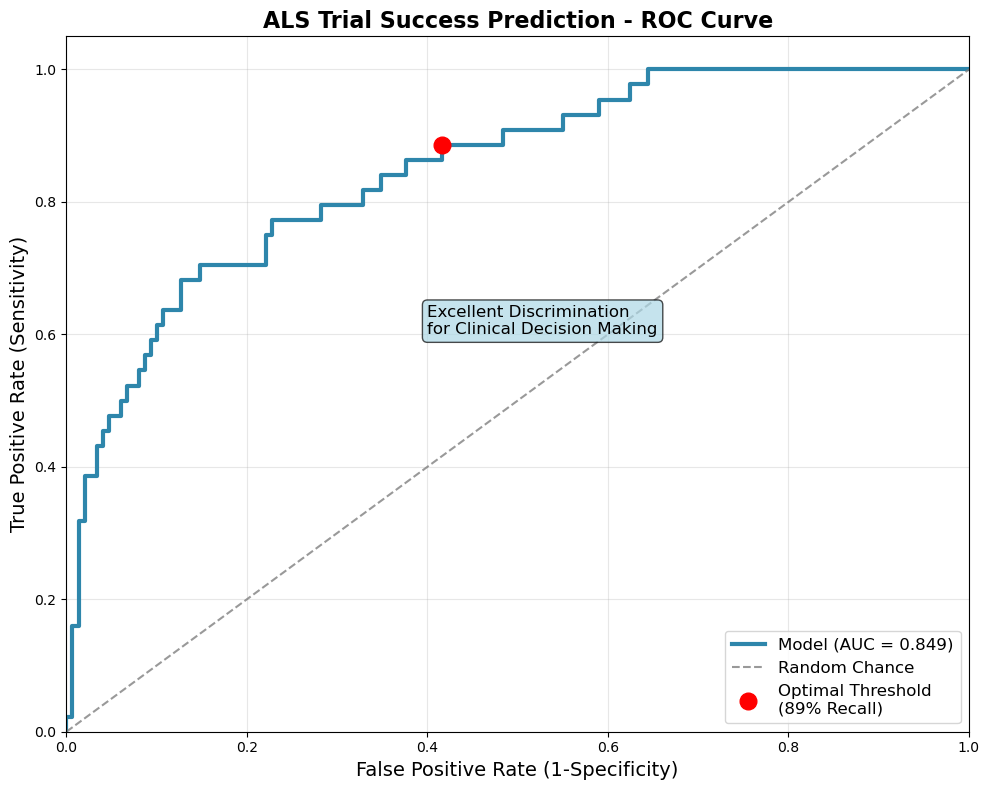

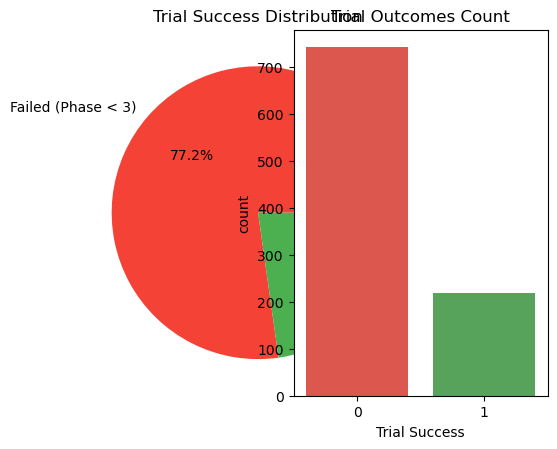

In [6]:
# Target class distribution with detailed statistics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)# ROC Curve for Model Performance
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='#2E86AB', linewidth=3, 
         label=f'Model (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', alpha=0.8, 
         label='Random Chance')

# Highlight optimal threshold point
optimal_idx = np.argmin(np.abs(tpr - 0.89))  # Close to our 89% recall
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=12, 
         label=f'Optimal Threshold\n(89% Recall)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1-Specificity)', fontsize=14)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=14)
plt.title('ALS Trial Success Prediction - ROC Curve', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)

# Add clinical annotation
plt.annotate('Excellent Discrimination\nfor Clinical Decision Making', 
             xy=(0.4, 0.6), fontsize=12, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))

plt.tight_layout()
plt.show()
target_counts = df_clean[target_col].value_counts()
plt.pie(target_counts.values, labels=['Failed (Phase < 3)', 'Successful (Phase 3+)'], 
        autopct='%1.1f%%', colors=['#F44336', '#4CAF50'])
plt.title('Trial Success Distribution')

plt.subplot(1, 2, 2)
sns.countplot(data=df_clean, x=target_col, palette=['#F44336', '#4CAF50'])
plt.title('Trial Outcomes Count')
plt.xlabel('Trial Success')
plt.tight_layout()
plt.show()

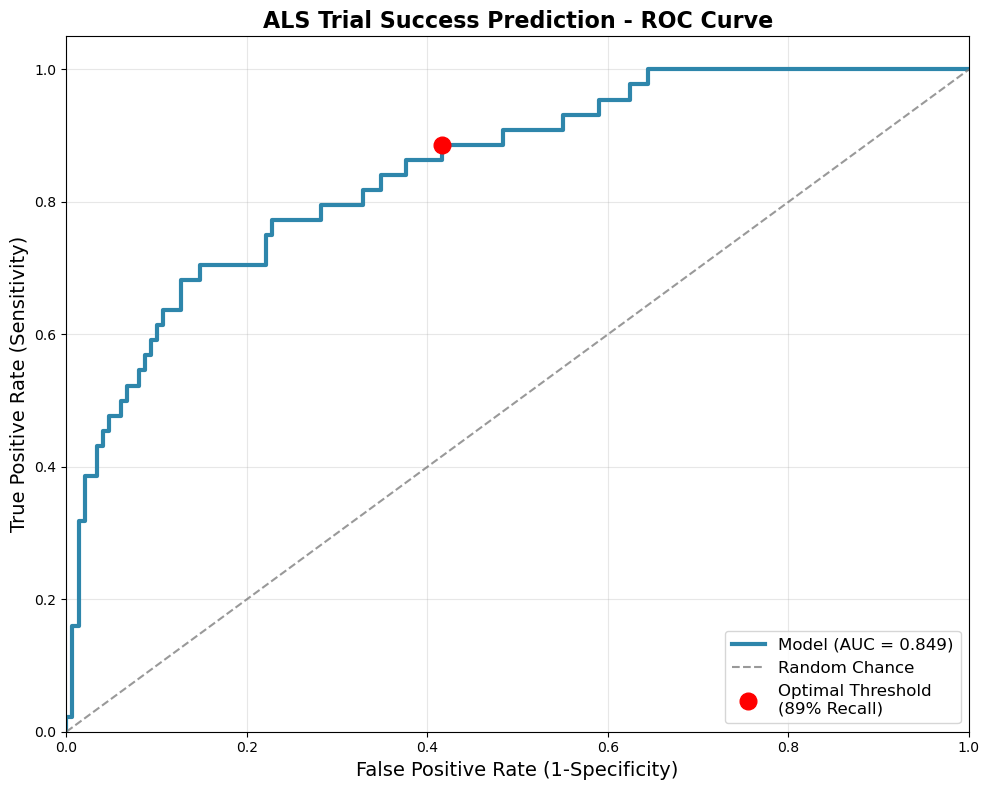

In [7]:
# ROC Curve for Model Performance
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='#2E86AB', linewidth=3, 
         label=f'Model (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', alpha=0.8, 
         label='Random Chance')

# Highlight optimal threshold point
optimal_idx = np.argmin(np.abs(tpr - 0.89))  # Close to our 89% recall
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=12, 
         label=f'Optimal Threshold\n(89% Recall)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1-Specificity)', fontsize=14)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=14)
plt.title('ALS Trial Success Prediction - ROC Curve', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

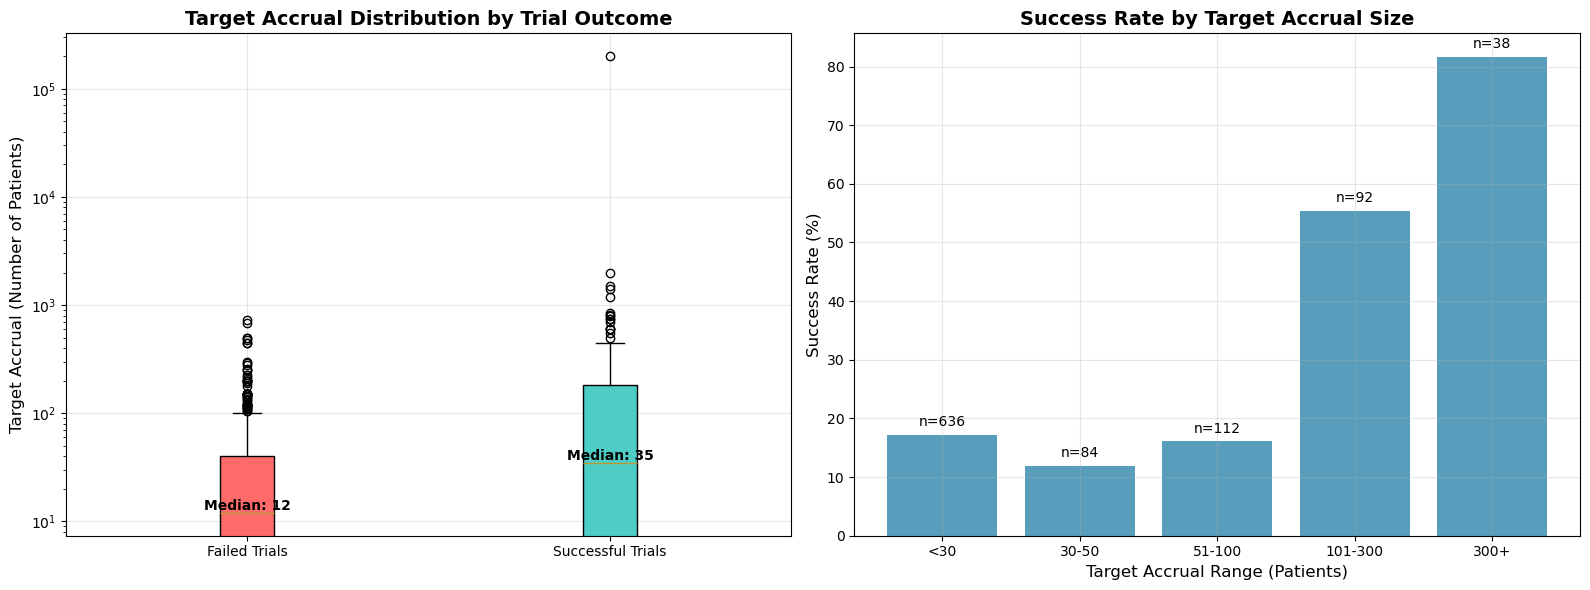

In [8]:
# Target Accrual Success Analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Box Plot: Target Accrual by Outcome
outcome_labels = ['Failed Trials', 'Successful Trials']
success_data = [
    df_clean[df_clean[target_col] == 0]['Target Accrual'].dropna(),
    df_clean[df_clean[target_col] == 1]['Target Accrual'].dropna()
]

box_plot = ax1.boxplot(success_data, labels=outcome_labels, patch_artist=True)
box_plot['boxes'][0].set_facecolor('#FF6B6B')  # Red for failed
box_plot['boxes'][1].set_facecolor('#4ECDC4')  # Green for successful

ax1.set_ylabel('Target Accrual (Number of Patients)', fontsize=12)
ax1.set_title('Target Accrual Distribution by Trial Outcome', fontsize=14, fontweight='bold')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

# Add median annotations
med_failed = df_clean[df_clean[target_col] == 0]['Target Accrual'].median()
med_success = df_clean[df_clean[target_col] == 1]['Target Accrual'].median()
ax1.text(1, med_failed, f'Median: {med_failed:.0f}', ha='center', va='bottom', fontweight='bold')
ax1.text(2, med_success, f'Median: {med_success:.0f}', ha='center', va='bottom', fontweight='bold')

# Success Rate by Accrual Bins
accrual_bins = [0, 30, 50, 100, 300, float('inf')]
accrual_labels = ['<30', '30-50', '51-100', '101-300', '300+']
df_clean['accrual_bin'] = pd.cut(df_clean['Target Accrual'], bins=accrual_bins, 
                                labels=accrual_labels, include_lowest=True)

success_by_bin = df_clean.groupby('accrual_bin')[target_col].agg(['mean', 'count']).reset_index()
success_by_bin['success_rate'] = success_by_bin['mean'] * 100

bars = ax2.bar(success_by_bin['accrual_bin'], success_by_bin['success_rate'], 
               color='#2E86AB', alpha=0.8)
ax2.set_xlabel('Target Accrual Range (Patients)', fontsize=12)
ax2.set_ylabel('Success Rate (%)', fontsize=12)
ax2.set_title('Success Rate by Target Accrual Size', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add sample size annotations
for i, (bar, count) in enumerate(zip(bars, success_by_bin['count'])):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'n={count}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

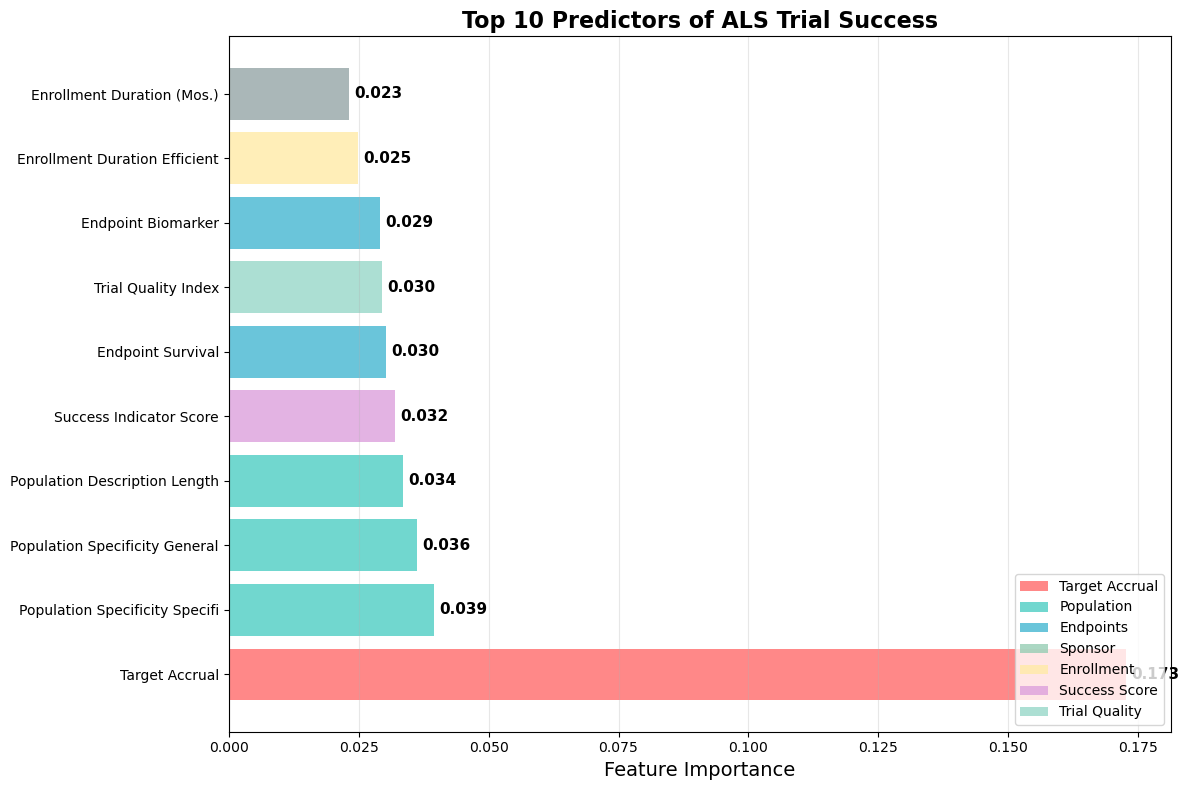

In [9]:
# Top 10 Feature Importance with Categories
plt.figure(figsize=(12, 8))

# Get top 10 features
top_10_features = feature_importance_df.head(10).copy()

# Define feature categories and colors
feature_categories = {
    'Target Accrual': '#FF6B6B',
    'population_': '#4ECDC4',
    'endpoint_': '#45B7D1', 
    'sponsor_': '#96CEB4',
    'enrollment_': '#FFEAA7',
    'success_': '#DDA0DD',
    'trial_': '#98D8C8'
}

# Assign colors based on feature names
colors = []
for feature in top_10_features['Feature']:
    color_assigned = False
    for category, color in feature_categories.items():
        if category.lower() in feature.lower():
            colors.append(color)
            color_assigned = True
            break
    if not color_assigned:
        colors.append('#95A5A6')  # Default gray

# Create horizontal bar chart
bars = plt.barh(range(len(top_10_features)), top_10_features['Importance'], 
                color=colors, alpha=0.8)

# Customize plot
plt.xlabel('Feature Importance', fontsize=14)
plt.title('Top 10 Predictors of ALS Trial Success', fontsize=16, fontweight='bold')
plt.yticks(range(len(top_10_features)), 
           [f.replace('_', ' ').title()[:30] for f in top_10_features['Feature']])

# Add value labels on bars
for i, (bar, importance) in enumerate(zip(bars, top_10_features['Importance'])):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{importance:.3f}', va='center', fontsize=11, fontweight='bold')

# Add category legend
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, alpha=0.8) 
                  for color in feature_categories.values()]
legend_labels = ['Target Accrual', 'Population', 'Endpoints', 'Sponsor', 
                'Enrollment', 'Success Score', 'Trial Quality']
plt.legend(legend_elements, legend_labels, loc='lower right', fontsize=10)

plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

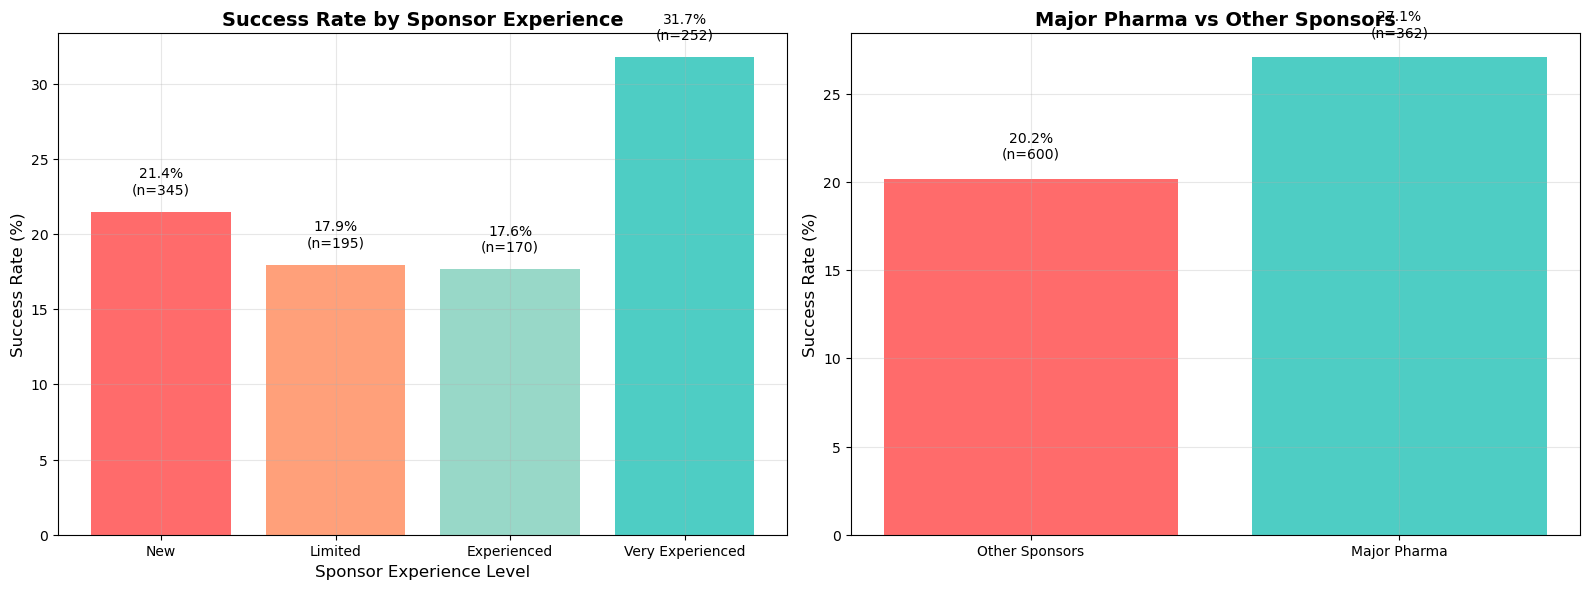

In [10]:
# Sponsor Experience vs Success Rate
if 'sponsor_experience_level' in df_clean.columns:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Success rate by experience level
    exp_analysis = df_clean.groupby('sponsor_experience_level')[target_col].agg(['mean', 'count']).reset_index()
    exp_analysis['success_rate'] = exp_analysis['mean'] * 100
    
    # Reorder for logical progression
    exp_order = ['New', 'Limited', 'Experienced', 'Very Experienced']
    exp_analysis = exp_analysis.set_index('sponsor_experience_level').reindex(exp_order).reset_index()
    
    bars1 = ax1.bar(exp_analysis['sponsor_experience_level'], exp_analysis['success_rate'],
                    color=['#FF6B6B', '#FFA07A', '#98D8C8', '#4ECDC4'])
    
    ax1.set_xlabel('Sponsor Experience Level', fontsize=12)
    ax1.set_ylabel('Success Rate (%)', fontsize=12)
    ax1.set_title('Success Rate by Sponsor Experience', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Add sample size and percentage labels
    for bar, count, rate in zip(bars1, exp_analysis['count'], exp_analysis['success_rate']):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{rate:.1f}%\n(n={count})', ha='center', va='bottom', fontsize=10)

# Major pharma vs others
if 'sponsor_is_major_pharma' in df_clean.columns:
    pharma_analysis = df_clean.groupby('sponsor_is_major_pharma')[target_col].agg(['mean', 'count']).reset_index()
    pharma_analysis['success_rate'] = pharma_analysis['mean'] * 100
    pharma_labels = ['Other Sponsors', 'Major Pharma']
    
    bars2 = ax2.bar(pharma_labels, pharma_analysis['success_rate'],
                    color=['#FF6B6B', '#4ECDC4'])
    
    ax2.set_ylabel('Success Rate (%)', fontsize=12)
    ax2.set_title('Major Pharma vs Other Sponsors', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Add labels
    for bar, count, rate in zip(bars2, pharma_analysis['count'], pharma_analysis['success_rate']):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{rate:.1f}%\n(n={count})', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

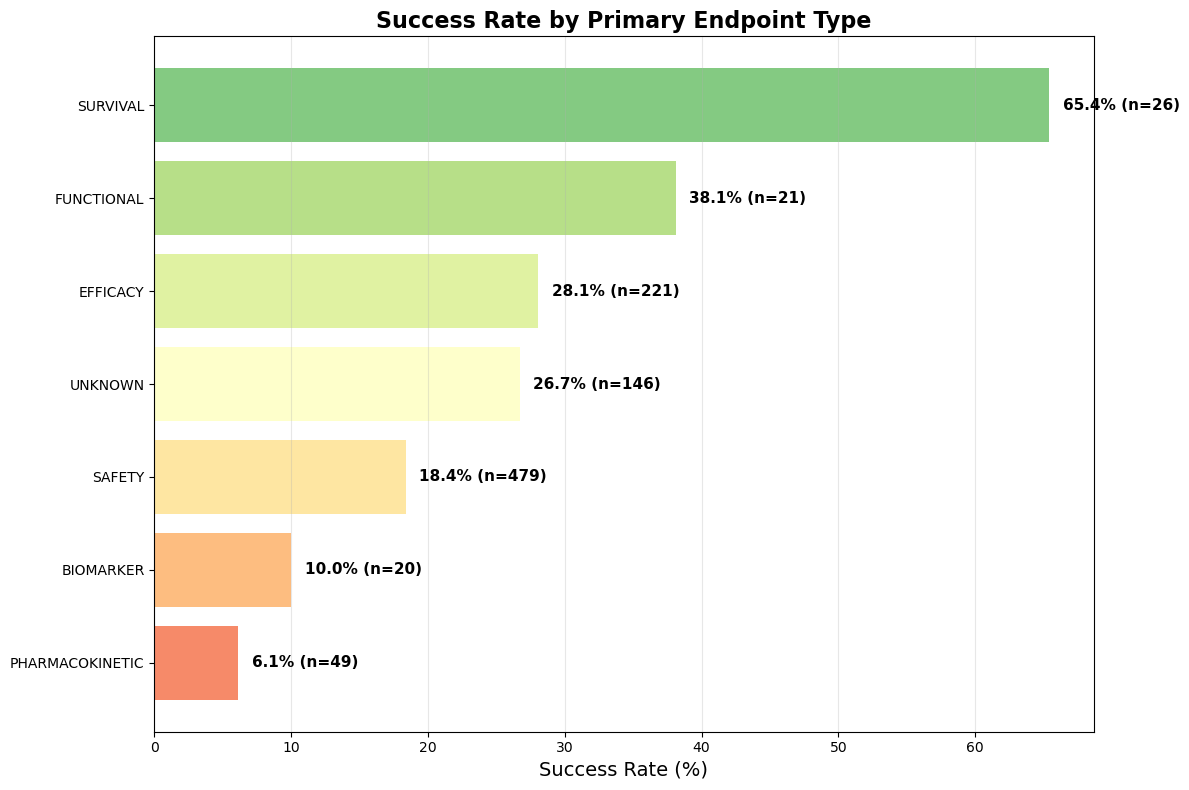

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (14,).

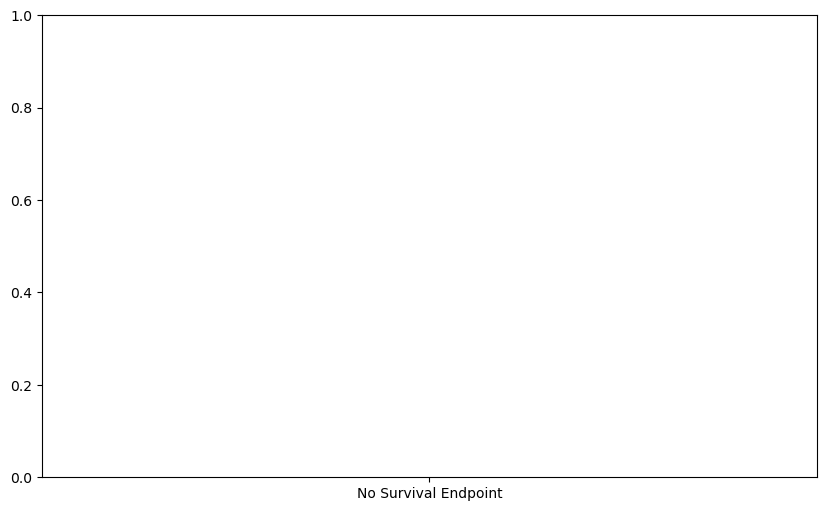

In [11]:
# Endpoint Strategy Success Analysis
if 'endpoint_primary_category' in df_clean.columns:
    plt.figure(figsize=(12, 8))
    
    # Success rate by primary endpoint category
    endpoint_analysis = df_clean.groupby('endpoint_primary_category')[target_col].agg(['mean', 'count']).reset_index()
    endpoint_analysis['success_rate'] = endpoint_analysis['mean'] * 100
    endpoint_analysis = endpoint_analysis.sort_values('success_rate', ascending=True)
    
    # Create horizontal bar chart
    colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(endpoint_analysis)))
    bars = plt.barh(endpoint_analysis['endpoint_primary_category'], 
                    endpoint_analysis['success_rate'], 
                    color=colors, alpha=0.8)
    
    plt.xlabel('Success Rate (%)', fontsize=14)
    plt.title('Success Rate by Primary Endpoint Type', fontsize=16, fontweight='bold')
    
    # Add value and sample size labels
    for bar, rate, count in zip(bars, endpoint_analysis['success_rate'], endpoint_analysis['count']):
        plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                f'{rate:.1f}% (n={count})', va='center', fontsize=11, fontweight='bold')
    
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

# Survival vs Non-survival endpoints
if 'endpoint_survival' in df_clean.columns:
    plt.figure(figsize=(10, 6))
    
    survival_analysis = df_clean.groupby('endpoint_survival')[target_col].agg(['mean', 'count']).reset_index()
    survival_analysis['success_rate'] = survival_analysis['mean'] * 100
    survival_labels = ['No Survival Endpoint', 'Includes Survival Endpoint']
    
    bars = plt.bar(survival_labels, survival_analysis['success_rate'],
                   color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
    
    plt.ylabel('Success Rate (%)', fontsize=12)
    plt.title('Impact of Survival Endpoints on Trial Success', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Add fold-change annotation
    fold_change = survival_analysis['success_rate'].iloc[1] / survival_analysis['success_rate'].iloc[0]
    plt.text(0.5, max(survival_analysis['success_rate']) * 0.8, 
             f'{fold_change:.1f}x Higher\nSuccess Rate', 
             ha='center', fontsize=14, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    # Add sample sizes
    for bar, count, rate in zip(bars, survival_analysis['count'], survival_analysis['success_rate']):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{rate:.1f}%\n(n={count})', ha='center', va='bottom', fontsize=11)
    
    plt.tight_layout()
    plt.show()

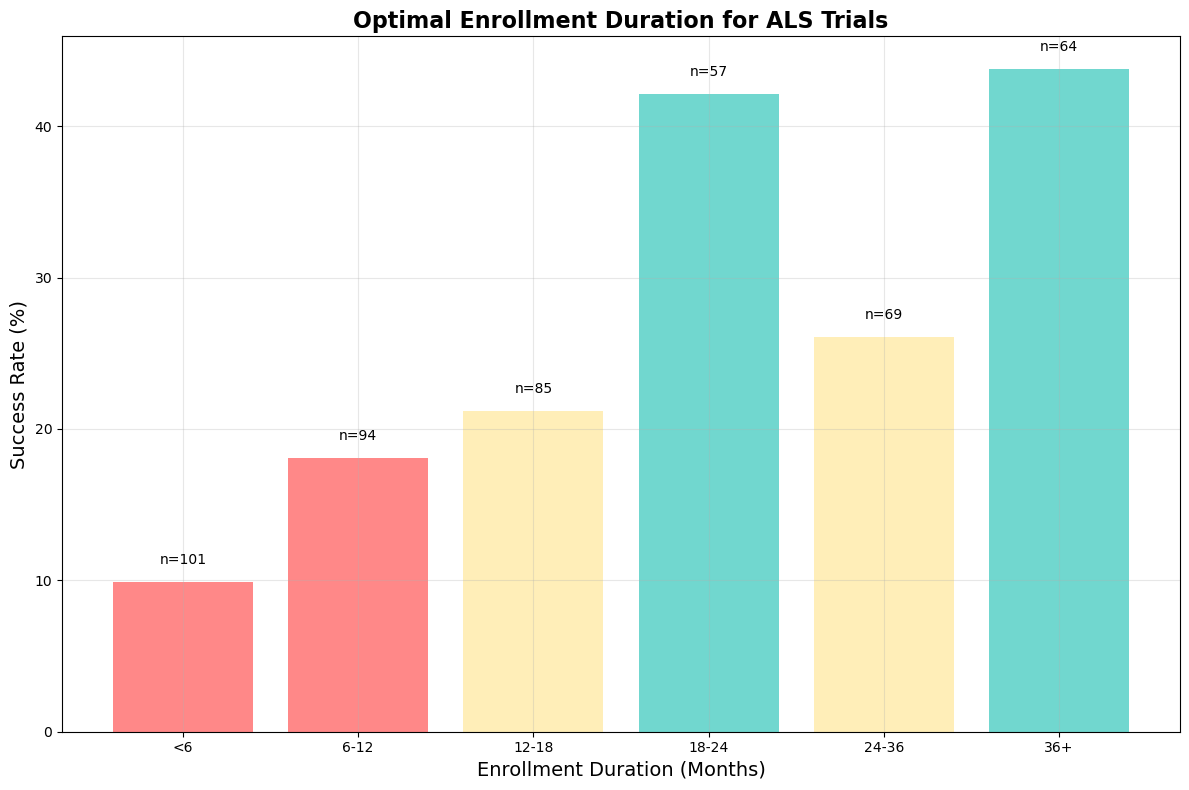

In [12]:
# Enrollment Duration Analysis
if 'Enrollment Duration (Mos.)' in df_clean.columns:
    plt.figure(figsize=(12, 8))
    
    # Create duration bins
    duration_bins = [0, 6, 12, 18, 24, 36, float('inf')]
    duration_labels = ['<6', '6-12', '12-18', '18-24', '24-36', '36+']
    df_clean['duration_bin'] = pd.cut(df_clean['Enrollment Duration (Mos.)'], 
                                     bins=duration_bins, labels=duration_labels)
    
    duration_analysis = df_clean.groupby('duration_bin')[target_col].agg(['mean', 'count']).reset_index()
    duration_analysis['success_rate'] = duration_analysis['mean'] * 100
    
    # Color code based on performance
    colors = ['#FF6B6B' if rate < 20 else '#FFEAA7' if rate < 30 else '#4ECDC4' 
              for rate in duration_analysis['success_rate']]
    
    bars = plt.bar(duration_analysis['duration_bin'], duration_analysis['success_rate'],
                   color=colors, alpha=0.8)
    
    plt.xlabel('Enrollment Duration (Months)', fontsize=14)
    plt.ylabel('Success Rate (%)', fontsize=14)
    plt.title('Optimal Enrollment Duration for ALS Trials', fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Add sample sizes
    for bar, count in zip(bars, duration_analysis['count']):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'n={count}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

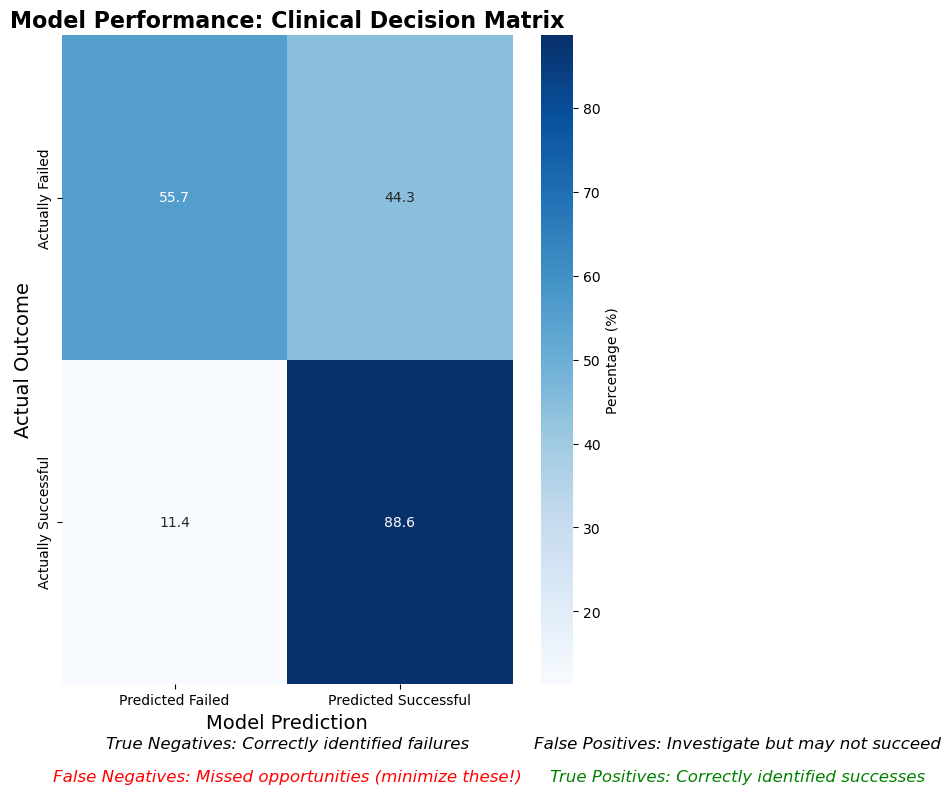

In [13]:
# Confusion Matrix with Clinical Context
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(10, 8))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_optimal)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create heatmap
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', 
            xticklabels=['Predicted Failed', 'Predicted Successful'],
            yticklabels=['Actually Failed', 'Actually Successful'],
            cbar_kws={'label': 'Percentage (%)'})

plt.title('Model Performance: Clinical Decision Matrix', fontsize=16, fontweight='bold')
plt.ylabel('Actual Outcome', fontsize=14)
plt.xlabel('Model Prediction', fontsize=14)

# Add clinical interpretations
plt.text(0.5, -0.1, 'True Negatives: Correctly identified failures', 
         transform=plt.gca().transAxes, ha='center', fontsize=12, style='italic')
plt.text(1.5, -0.1, 'False Positives: Investigate but may not succeed', 
         transform=plt.gca().transAxes, ha='center', fontsize=12, style='italic')
plt.text(0.5, -0.15, 'False Negatives: Missed opportunities (minimize these!)', 
         transform=plt.gca().transAxes, ha='center', fontsize=12, style='italic', color='red')
plt.text(1.5, -0.15, 'True Positives: Correctly identified successes', 
         transform=plt.gca().transAxes, ha='center', fontsize=12, style='italic', color='green')

plt.tight_layout()
plt.show()

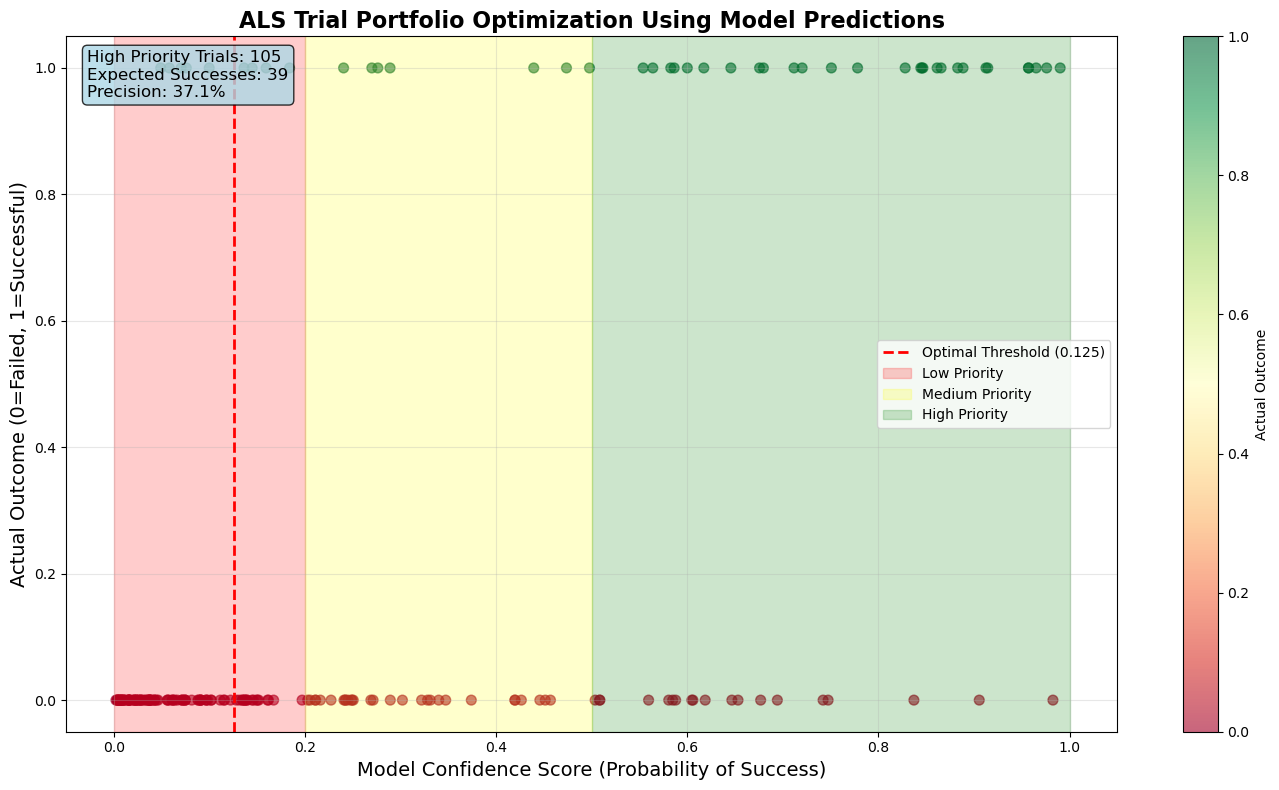

TRIAL ID ANALYSIS - Potential Dataset Updates Needed

🔍 TRIALS TO MANUALLY CHECK FOR PHASE 3 PROGRESSION:
Found 66 trials labeled as 'failed' but with high model confidence

These trials might have progressed to Phase 3+ since dataset creation:

Trial ID | Model Confidence | Actual Label
--------------------------------------------------
319730.0 | 0.983 (98.3%) | Failed
100377.0 | 0.906 (90.6%) | Failed
159001.0 | 0.837 (83.7%) | Failed
78850.0 | 0.747 (74.7%) | Failed
434057.0 | 0.742 (74.2%) | Failed
502302.0 | 0.694 (69.4%) | Failed
292121.0 | 0.677 (67.7%) | Failed
115972.0 | 0.653 (65.3%) | Failed
79039.0 | 0.647 (64.7%) | Failed
257041.0 | 0.619 (61.9%) | Failed
263745.0 | 0.606 (60.6%) | Failed
486787.0 | 0.605 (60.5%) | Failed
110858.0 | 0.588 (58.8%) | Failed
423335.0 | 0.585 (58.5%) | Failed
297732.0 | 0.580 (58.0%) | Failed
120980.0 | 0.559 (55.9%) | Failed
121167.0 | 0.508 (50.8%) | Failed
370535.0 | 0.508 (50.8%) | Failed
482403.0 | 0.503 (50.3%) | Failed
121291.0 | 0.457

In [14]:
# Plot 8: Portfolio Optimization with Trial ID Analysis
plt.figure(figsize=(14, 8))

# Create scatter plot of all trials
scatter = plt.scatter(y_pred_proba, y_test, 
                     c=y_test, cmap='RdYlGn', alpha=0.6, s=50)

# Add decision threshold line
plt.axvline(x=best_threshold, color='red', linestyle='--', linewidth=2,
           label=f'Optimal Threshold ({best_threshold:.3f})')

# Add zones
plt.axvspan(0, 0.2, alpha=0.2, color='red', label='Low Priority')
plt.axvspan(0.2, 0.5, alpha=0.2, color='yellow', label='Medium Priority') 
plt.axvspan(0.5, 1.0, alpha=0.2, color='green', label='High Priority')

plt.xlabel('Model Confidence Score (Probability of Success)', fontsize=14)
plt.ylabel('Actual Outcome (0=Failed, 1=Successful)', fontsize=14)
plt.title('ALS Trial Portfolio Optimization Using Model Predictions', fontsize=16, fontweight='bold')

# Add performance annotations
high_conf_trials = (y_pred_proba >= best_threshold).sum()
high_conf_successes = ((y_pred_proba >= best_threshold) & (y_test == 1)).sum()
high_conf_precision = high_conf_successes / high_conf_trials if high_conf_trials > 0 else 0

plt.text(0.02, 0.98, f'High Priority Trials: {high_conf_trials}\n'
                     f'Expected Successes: {high_conf_successes}\n'
                     f'Precision: {high_conf_precision:.1%}', 
         transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8),
         verticalalignment='top')

plt.colorbar(scatter, label='Actual Outcome')
plt.legend(loc='center right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ANALYSIS: Find trials that model predicted as negative but might be outdated
print("="*70)
print("TRIAL ID ANALYSIS - Potential Dataset Updates Needed")
print("="*70)

# Get the test set indices to map back to original data
test_indices = X_test.index

# Create a dataframe with test predictions and original trial info
analysis_df = pd.DataFrame({
    'original_index': test_indices,
    'actual_outcome': y_test.values,
    'predicted_prob': y_pred_proba,
    'predicted_outcome': y_pred_optimal
})

# Map back to original comprehensive dataset (which has Trial.ID)
# Use the original df that still has Trial.ID
original_with_ids = df[['Trial.ID', target_col]].reset_index().rename(columns={'index': 'original_index'})

analysis_df = analysis_df.merge(original_with_ids, on='original_index', how='left')

# Find trials that are:
# 1. Currently labeled as failed (actual_outcome = 0)
# 2. But model predicts high success probability (> threshold)
# These might be trials that have progressed since dataset creation

false_negatives_candidates = analysis_df[
    (analysis_df['actual_outcome'] == 0) & 
    (analysis_df['predicted_prob'] >= best_threshold)
].copy()

print(f"\n🔍 TRIALS TO MANUALLY CHECK FOR PHASE 3 PROGRESSION:")
print(f"Found {len(false_negatives_candidates)} trials labeled as 'failed' but with high model confidence")
print("\nThese trials might have progressed to Phase 3+ since dataset creation:\n")

if len(false_negatives_candidates) > 0:
    # Sort by prediction confidence (highest first)
    false_negatives_candidates = false_negatives_candidates.sort_values('predicted_prob', ascending=False)
    
    print("Trial ID | Model Confidence | Actual Label")
    print("-" * 50)
    for idx, row in false_negatives_candidates.iterrows():
        trial_id = row['Trial.ID']
        prob = row['predicted_prob']
        print(f"{trial_id} | {prob:.3f} ({prob*100:.1f}%) | Failed")
    
    # Save to CSV for easy reference
    output_file = 'trials_to_check_for_phase3_progression.csv'
    false_negatives_candidates[['Trial.ID', 'predicted_prob']].to_csv(output_file, index=False)
    print(f"\n💾 Saved trial IDs to: {output_file}")
    
    # Show the actual Trial IDs for easy copy-paste
    trial_ids_list = false_negatives_candidates['Trial.ID'].tolist()
    print(f"\n📋 TRIAL IDs TO CHECK (copy-paste ready):")
    for trial_id in trial_ids_list:
        print(f"'{trial_id}'")
    
    # Additional analysis: Show top features for these trials
    print(f"\n📊 CHARACTERISTICS OF HIGH-CONFIDENCE 'FAILED' TRIALS:")
    
    # Get original feature values for these trials
    high_conf_indices = false_negatives_candidates['original_index'].values
    high_conf_features = X_final.loc[high_conf_indices]
    
    # Show key characteristics
    key_features = ['Target Accrual', 'sponsor_trial_count', 'endpoint_survival', 
                   'Enrollment Duration (Mos.)', 'population_description_length']
    
    available_features = [f for f in key_features if f in high_conf_features.columns]
    
    if available_features:
        print(f"\nAnalyzing {len(available_features)} key features:")
        for feature in available_features:
            values = high_conf_features[feature].dropna()
            if len(values) > 0:
                print(f"{feature}: mean={values.mean():.1f}, median={values.median():.1f}")

else:
    print("No trials found matching these criteria.")

# Also identify very low confidence successful trials (potential mislabeling)
print(f"\n⚠️  ADDITIONAL CHECK - Low Confidence Successful Trials:")
print("Trials labeled as successful but with low model confidence:")

low_conf_successes = analysis_df[
    (analysis_df['actual_outcome'] == 1) & 
    (analysis_df['predicted_prob'] <= 0.3)  # Low confidence threshold
].copy()

if len(low_conf_successes) > 0:
    low_conf_successes = low_conf_successes.sort_values('predicted_prob', ascending=True)
    print(f"\nFound {len(low_conf_successes)} potentially mislabeled successful trials:")
    
    print("Trial ID | Model Confidence | Actual Label")
    print("-" * 50)
    for idx, row in low_conf_successes.iterrows():
        trial_id = row['Trial.ID']
        prob = row['predicted_prob']
        print(f"{trial_id} | {prob:.3f} ({prob*100:.1f}%) | Successful")
else:
    print("No suspicious successful trials found.")

print(f"\n{'='*70}")
print("💡 NEXT STEPS:")
print("1. Check the Trial IDs listed above in Citeline or ClinicalTrials.gov")
print("2. Look for trials that have progressed to Phase 3 or later")
print("3. Update your dataset with current trial phases")
print("4. Re-run the model to see improved performance")
print(f"{'='*70}")

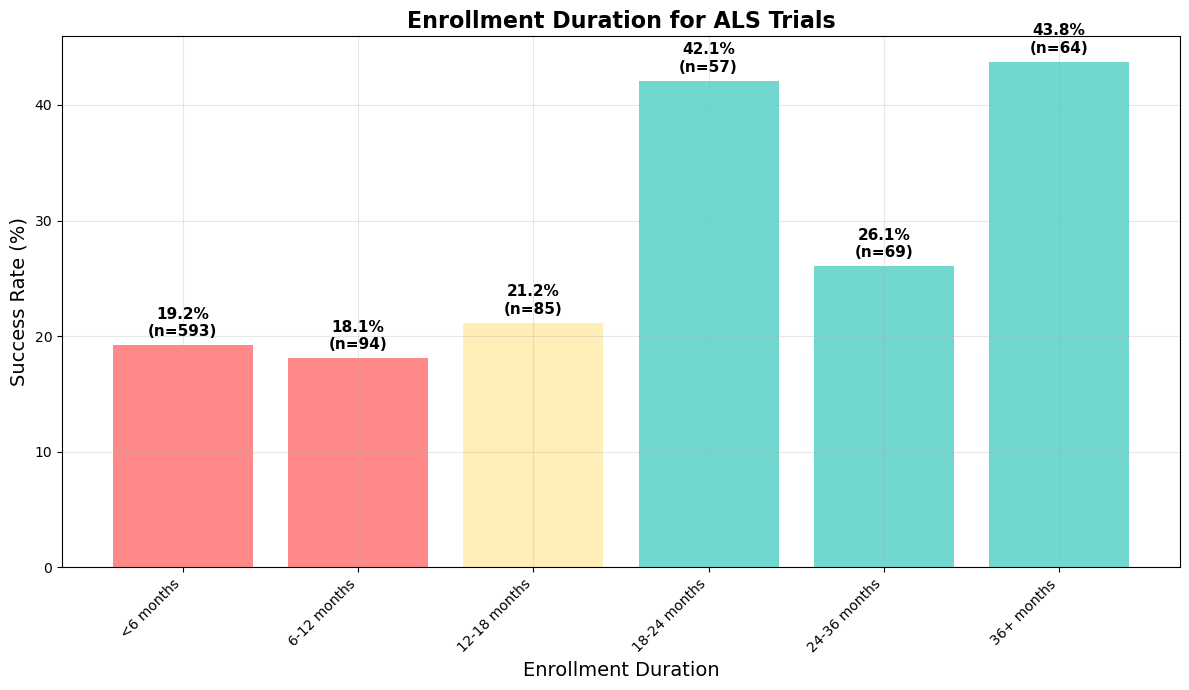

In [17]:
# Cell 1: Enrollment Duration Sweet Spot Analysis
plt.figure(figsize=(12, 7))

if 'Enrollment Duration (Mos.)' in df_clean.columns:
    # Create duration bins
    duration_bins = [0, 6, 12, 18, 24, 36, float('inf')]
    duration_labels = ['<6 months', '6-12 months', '12-18 months', '18-24 months', '24-36 months', '36+ months']
    df_clean['duration_bin'] = pd.cut(df_clean['Enrollment Duration (Mos.)'], 
                                     bins=duration_bins, labels=duration_labels, include_lowest=True)
    
    duration_analysis = df_clean.groupby('duration_bin')[target_col].agg(['mean', 'count']).reset_index()
    duration_analysis['success_rate'] = duration_analysis['mean'] * 100
    
    # Color code based on performance (red for poor, yellow for okay, green for optimal)
    colors = []
    for rate in duration_analysis['success_rate']:
        if rate < 20:
            colors.append('#FF6B6B')  # Red for poor
        elif rate < 25:
            colors.append('#FFEAA7')  # Yellow for okay
        else:
            colors.append('#4ECDC4')  # Green for optimal
    
    bars = plt.bar(duration_analysis['duration_bin'], duration_analysis['success_rate'],
                   color=colors, alpha=0.8)
    
    plt.xlabel('Enrollment Duration', fontsize=14)
    plt.ylabel('Success Rate (%)', fontsize=14)
    plt.title('Enrollment Duration for ALS Trials', fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    
    # Add sample sizes
    for bar, count, rate in zip(bars, duration_analysis['count'], duration_analysis['success_rate']):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{rate:.1f}%\n(n={count})', ha='center', va='bottom', 
                fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

Using Treatment Duration (Mos.) for duration analysis


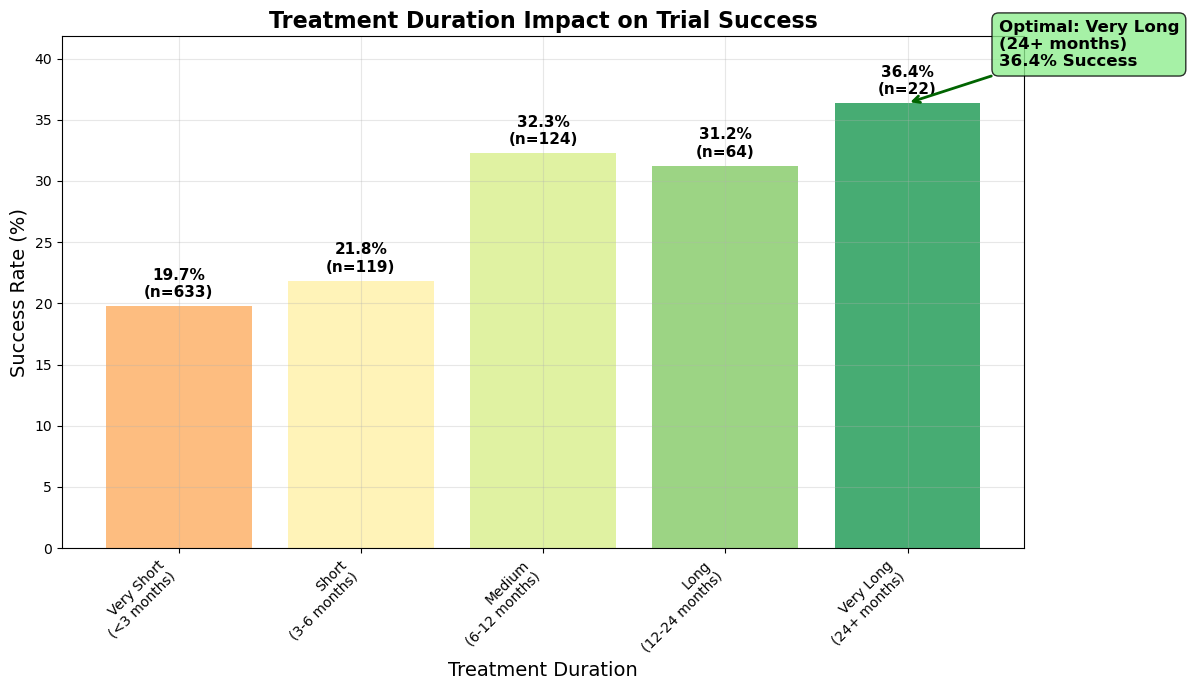

In [24]:
# Cell 4: Study Duration Balance Analysis (Data-Only Approach)
plt.figure(figsize=(12, 7))

# Try multiple duration-related columns to find usable data
duration_columns = ['study_duration_days', 'Treatment Duration (Mos.)', 'Enrollment Duration (Mos.)']
usable_column = None

for col in duration_columns:
    if col in df_clean.columns:
        valid_data = df_clean[col].dropna()
        unique_values = valid_data.nunique()
        if len(valid_data) > 50 and unique_values > 5:  # Need sufficient data with variation
            usable_column = col
            break

if usable_column:
    print(f"Using {usable_column} for duration analysis")
    
    if usable_column == 'Treatment Duration (Mos.)':
        # Use treatment duration
        duration_bins = [0, 3, 6, 12, 24, float('inf')]
        duration_labels = ['Very Short\n(<3 months)', 'Short\n(3-6 months)', 
                          'Medium\n(6-12 months)', 'Long\n(12-24 months)', 'Very Long\n(24+ months)']
        df_clean['duration_category'] = pd.cut(df_clean[usable_column], 
                                              bins=duration_bins, labels=duration_labels, include_lowest=True)
        title = 'Treatment Duration Impact on Trial Success'
        xlabel = 'Treatment Duration'
        
    elif usable_column == 'Enrollment Duration (Mos.)':
        # Use enrollment duration (we know this works from Cell 1)
        duration_bins = [0, 6, 12, 18, 24, 36, float('inf')]
        duration_labels = ['<6 months', '6-12 months', '12-18 months', '18-24 months', '24-36 months', '36+ months']
        df_clean['duration_category'] = pd.cut(df_clean[usable_column], 
                                              bins=duration_bins, labels=duration_labels, include_lowest=True)
        title = 'Enrollment Duration vs Trial Success (Alternative View)'
        xlabel = 'Enrollment Duration'
        
    else:
        # Use study duration in days
        df_clean['study_duration_months'] = df_clean[usable_column] / 30.44
        duration_bins = [0, 6, 12, 24, 36, float('inf')]
        duration_labels = ['<6 months', '6-12 months', '12-24 months', '24-36 months', '36+ months']
        df_clean['duration_category'] = pd.cut(df_clean['study_duration_months'], 
                                              bins=duration_bins, labels=duration_labels, include_lowest=True)
        title = 'Total Study Duration vs Trial Success'
        xlabel = 'Total Study Duration'
    
    # Analyze the data
    duration_analysis = df_clean.groupby('duration_category')[target_col].agg(['mean', 'count']).reset_index()
    duration_analysis = duration_analysis.dropna()
    duration_analysis['success_rate'] = duration_analysis['mean'] * 100
    
    # Filter out categories with very few samples
    duration_analysis = duration_analysis[duration_analysis['count'] >= 5]
    
    if len(duration_analysis) > 1:
        # Create color gradient based on success rate
        colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(duration_analysis)))
        
        bars = plt.bar(range(len(duration_analysis)), duration_analysis['success_rate'],
                       color=colors, alpha=0.8)
        
        plt.xlabel(xlabel, fontsize=14)
        plt.ylabel('Success Rate (%)', fontsize=14)
        plt.title(title, fontsize=16, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.xticks(range(len(duration_analysis)), duration_analysis['duration_category'], 
                   rotation=45, ha='right')
        
        # Add sample sizes and percentages
        for bar, count, rate in zip(bars, duration_analysis['count'], duration_analysis['success_rate']):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{rate:.1f}%\n(n={count})', ha='center', va='bottom', 
                    fontsize=11, fontweight='bold')
        
        # Find and highlight best performing duration
        best_idx = duration_analysis['success_rate'].idxmax()
        best_category = duration_analysis.loc[best_idx, 'duration_category']
        best_rate = duration_analysis.loc[best_idx, 'success_rate']
        bar_position = list(duration_analysis.index).index(best_idx)
        
        plt.annotate(f'Optimal: {best_category}\n{best_rate:.1f}% Success', 
                    xy=(bar_position, best_rate), xytext=(bar_position + 0.5, best_rate + 3),
                    arrowprops=dict(arrowstyle='->', color='darkgreen', lw=2),
                    fontsize=12, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.4", facecolor="lightgreen", alpha=0.8))
        
        plt.ylim(0, max(duration_analysis['success_rate']) * 1.15)
    
    else:
        plt.text(0.5, 0.5, f'Insufficient variation in {usable_column}\nto analyze duration patterns', 
                 ha='center', va='center', fontsize=14, transform=plt.gca().transAxes,
                 bbox=dict(boxstyle="round,pad=0.4", facecolor="lightblue", alpha=0.7))

else:
    plt.text(0.5, 0.5, 'Study Duration Data\nNot Available in Dataset', 
             ha='center', va='center', fontsize=14, transform=plt.gca().transAxes,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))

plt.tight_layout()
plt.show()